In [10]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import scipy.stats as ss
plt.rcParams.update({'font.size': 18})

Align FASTQ to reference genome.
```
minimap2 -t 8 -ax map-ont ../../ref/GCA_002057885.1_ASM205788v1_genomic.fna ../fq/combined.meth.fq | sambamba view -S -f bam /dev/stdin | sambamba sort -o combined.meth.bam
```
Call methylation events.
```
~/src/nanopolish/nanopolish call-methylation -t 8 -r ../fq/combined.meth.fq -b ../bam/combined.meth.bam -g ../../ref/GCA_002057885.1_ASM205788v1_genomic.fna > meth.tsv
```
Convert raw methylation calls to per-site frequencies.
```
~/src/nanopolish/scripts/calculate_methylation_frequency.py -i meth.tsv > meth.frequency.tsv
```

### Read in TSV files containing summary methylation information

Each file contains thousands of rows -- each row summarizes the methylation signal at a particular region of the genome.

In [3]:
methylation = pd.read_csv('meth.frequency.tsv', sep='\t')
control = pd.read_csv('control.frequency.tsv', sep='\t')

#### Check out the contents of each file

In [4]:
methylation.head()

,chromosome,start,end,num_motifs_in_group,called_sites,called_sites_methylated,methylated_frequency,group_sequence
0,chr1,160,164,2,2,0,0.0,TCCCTCGTTCGTATT
1,chr1,189,189,1,1,0,0.0,CTTACCGTCCT
2,chr1,209,209,1,1,0,0.0,CACAACGTAAT
3,chr1,231,231,1,1,0,0.0,CAACTCGATTG
4,chr1,294,298,2,2,0,0.0,CAACACGCCCGGAGA


### Merge the methylation and control files, so that we can access both sets of information at each site

Note: this merged file will only include information about sites that had both control and methylation signal.

In [5]:
# merge the two files by chromosome and position
join_keys = ['chromosome', 'start', 'end']
merged = pd.merge(methylation, control, left_on=join_keys, right_on=join_keys)

# remove extraneous columns from the merged dataframe
merged = merged[['chromosome', 'start', 'end', 'called_sites_x', 'methylated_frequency_x',
                                               'called_sites_y', 'methylated_frequency_y']]

# rename the columns in the merged dataframe to be more readable
merged = merged.rename(columns={'called_sites_x':'called_sites_meth',
                                'methylated_frequency_x':'methylated_frequency_meth',
                                'called_sites_y':'called_sites_control',
                                'methylated_frequency_y':'methylated_frequency_control',})

### Calculate the "net methylation signal" at each site

We do this (naively) by subtracting any signal present in the control data from the experimental data. At some sites, for whatever reason, there is more methylation in the control data than there is in the experimental data. We'll remove these sites, as well as any sites where we didn't have at least 10 reads aligned, and sites with more than 100 reads aligned. The latter often indicate pileups of poorly mapped reads.

In [7]:
merged['methylated_frequency'] = merged['methylated_frequency_meth'] - merged['methylated_frequency_control']
merged = merged.query('methylated_frequency > 0 & called_sites_meth > 10 & called_sites_control > 10')
merged = merged.query('called_sites_meth < 100 & called_sites_control < 100')

### Plot the methylation and control signals across the genome

This function accepts two dataframes (i.e., the control and experimental data), and plots the raw methylated frequency of every region on a particular chromosome.

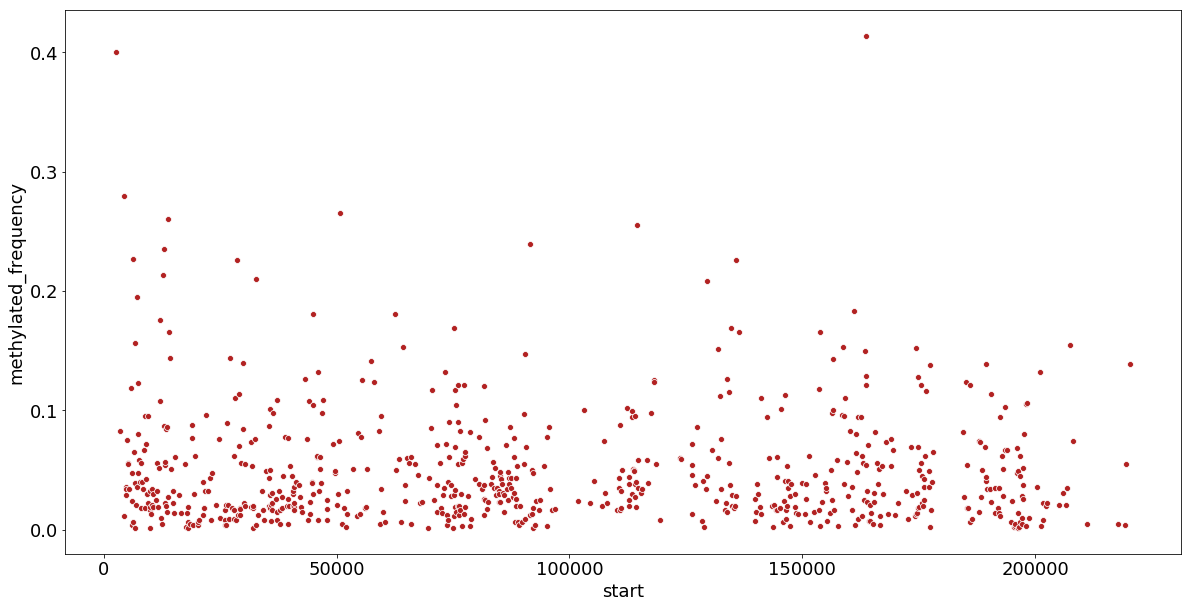

In [11]:
def basic_plot(df1, df2=None, chrom='chr1', key='methylated_frequency'):
    f, ax = plt.subplots(figsize=(20,10))

    colors = {0:'firebrick', 1:'dodgerblue'}
    for i,df in enumerate((df1, df2)):
        if df is None: continue
        df = df[df['chromosome'] == chrom]
        sns.scatterplot(x="start", y=key, data=df, ax=ax, color=colors[i])
    
basic_plot(merged, chrom='chr1')

### Plot mean methylation frequencies in bins across the genome

Rather than plotting raw signal, we can instead bin the raw signals and average within each bin. 

In [1]:
def mean_signal_per_window(sites_signal, max_pos=1, window_size=1000):
    """
    mean signal in non-overlapping windows 
    of specified size
    
    sites_signal: list of tuples formatted like (site, signal)
    max_pos: the last chromosomal position at which an event was recorded 
    window_size: desired size of windows to bin signals
    """
    import numpy as np
    # generate windows of the specified size
    windows = np.arange(0, max_pos, window_size)
    window_counts = defaultdict(list)
    # loop over every methylated site and catalog its 
    # window number, along with the signal at that site
    for s in sites_signal:
        bin_index = int(np.digitize(s[0], windows))
        window_counts[bin_index * window_size].append(s[1])
    return sorted(window_counts.items())

def bin_data(df, chrom='chr8', window_size=1):
    """
    given a dataframe, subset to the chromosome of interest
    and calculate the median signal per window
    """
    # filter to only include the chromosome of interest
    df = df[df['chromosome'] == chrom]
    # get arrays of positions and signals at those positions
    sites, signal = df['start'].values, df['methylated_frequency'].values
    # divide the data into `n_windows` and find the positions
    # that separate those windows (`edges`)
    max_pos = max(sites)    
    sites_signal = zip(sites, signal)
    # calculate the mean signal per window
    mean_signal = mean_signal_per_window(sites_signal, max_pos=max_pos, window_size=window_size)
    x_vals = np.array([x[0] for x in mean_signal])
    y_vals = np.array([np.mean(x[1]) for x in mean_signal])
    std = np.array([np.std([x[1]]) for x in mean_signal])
    return x_vals, y_vals, std

f, ax = plt.subplots(figsize=(25,10))

# the chromosome we want to look at
chrom = 'chr4'

# the desired window size
window_size = 5000

# data to plot
df = merged

# get the bin coordinates and mean signal per bin
meth_x, meth_y, meth_std = bin_data(df, chrom=chrom, window_size=window_size)

# plot the mean methylation signal in each window, and indicate the positions where
# there is an "enrichment" of methylation signal (z-score of methylation signal is > 2.5)
sig_points = np.where(abs(ss.zscore(meth_y)) > 2.5)
ax.errorbar(meth_x, meth_y, yerr=meth_std, color="dodgerblue", label="methylation", lw=3, elinewidth=1., capsize=2)
ax.scatter(meth_x[sig_points], meth_y[sig_points], color='firebrick')

ax.legend(loc="upper left")
ax.set_ylabel("Mean methylation frequency (+/- STD)")
ax.set_xlabel("Position in chromosome (bp)")

NameError: name 'plt' is not defined